# Test 2
### Fit a parametric lens model (SIE + shear) given a fixed Sérsic source
as discussed in the meeting @Cubotron on 02.06.2021

In [1]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import numpy as np
from scipy.optimize import minimize

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# JAX-ified lenstronomy
from jaxtronomy.Data.pixel_grid import PixelGrid
from jaxtronomy.Data.psf import PSF
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.ImSim.image_model import ImageModel
from jaxtronomy.Util import image_util

# Universal font size
FS = 18

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15}]

### Lens model (SIE + external shear)

In [5]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

### PSF

In [6]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Image model

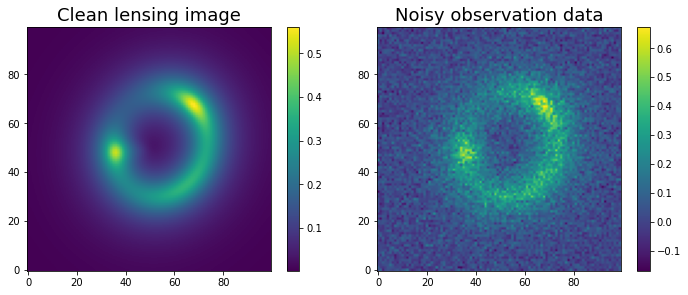

In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}
image_model = ImageModel(data_class=pixel_grid,
                         psf_class=psf,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         point_source_class=None,
                         kwargs_numerics=kwargs_numerics)

image = image_model.image(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light,
                          kwargs_ps={})

# Noise
exp_time = 100
sigma_bkd = 0.05
poisson = image_util.add_poisson(image, exp_time)
gaussian = image_util.add_background(image, sigma_bkd)

# Observed noisy data
data = image + gaussian + poisson

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Lens mass model fitting

### Loss function

In [8]:
def create_loss_func(data, model, noise_var=None):
    """Create a jit-compiled callable loss function.
    
    Parameters
    ----------
    data : 2D array
        Observed image.
    model : instance of a jaxtronomy ImageModel
        ImageModel instance with a callable image() method.
    noise_var : 2D array, optional
        Noise variance per pixel assuming independence, i.e.
        a diagonal covariance matrix.
    
    """
    if noise_var is None:
        noise_var = jnp.ones_like(data)
    assert noise_var.shape == data.shape, "Invalid noise variance map"
        
    def loss_func(params):
        # Compute reconstruction with these parameters
        rec = model.image(kwargs_lens=params['kwargs_lens_mass'],
                          kwargs_source=params['kwargs_source_light'],
                          kwargs_lens_light=params['kwargs_lens_light'],
                          kwargs_ps={})
        
        # Chi-square
        loss = 0.5 * jnp.mean((data - rec)**2 / noise_var)

        # Regularisation
        # loss += ...
        
        return loss
    return jax.jit(loss_func)

# Create loss and grad(loss) functions of parameter dictionaries
noise_var = jnp.abs(image) / exp_time + gaussian.var()
loss = create_loss_func(data, image_model, noise_var)
grad_loss = jax.jit(jax.grad(loss))

Check loss and gradient of the true parameters

In [9]:
p = {'kwargs_lens_mass': kwargs_lens_mass,
     'kwargs_source_light': kwargs_source_light,
     'kwargs_lens_light': kwargs_lens_light}

loss(p)

DeviceArray(0.50167858, dtype=float64)

In [10]:
grad_loss(p)

{'kwargs_lens_light': [{}],
 'kwargs_lens_mass': [{'center_x': DeviceArray(-0.00111666, dtype=float64),
   'center_y': DeviceArray(0.02382615, dtype=float64),
   'e1': DeviceArray(-0.00960378, dtype=float64),
   'e2': DeviceArray(2.97430242e-05, dtype=float64),
   'theta_E': DeviceArray(-0.02356831, dtype=float64)},
  {'gamma1': DeviceArray(0.01208906, dtype=float64),
   'gamma2': DeviceArray(-0.00153188, dtype=float64)}],
 'kwargs_source_light': [{'R_sersic': DeviceArray(0.00254528, dtype=float64),
   'amp': DeviceArray(0.00093965, dtype=float64),
   'center_x': DeviceArray(0.00791564, dtype=float64),
   'center_y': DeviceArray(-0.02159131, dtype=float64),
   'n_sersic': DeviceArray(0.00523695, dtype=float64)}]}

### Minimize the loss function over lens mass parameters using scipy

In [11]:
@jax.jit
def func(v):
    params = {'kwargs_lens_mass': [{'theta_E': v[0], 'e1': v[1], 'e2': v[2], 'center_x': v[3], 'center_y': v[4]},
                                   {'gamma1': v[5], 'gamma2': v[6]}],
              'kwargs_source_light': kwargs_source_light,
              'kwargs_lens_light': kwargs_lens_light}
    return loss(params)

@jax.jit
def grad_func(v):
    params = {'kwargs_lens_mass': [{'theta_E': v[0], 'e1': v[1], 'e2': v[2], 'center_x': v[3], 'center_y': v[4]},
                                   {'gamma1': v[5], 'gamma2': v[6]}],
              'kwargs_source_light': kwargs_source_light,
              'kwargs_lens_light': kwargs_lens_light}
    grad = grad_loss(params)['kwargs_lens_mass']
    return [grad[0]['theta_E'], grad[0]['e1'], grad[0]['e2'], grad[0]['center_x'], grad[0]['center_y'], 
            grad[1]['gamma1'], grad[1]['gamma2']]

In [12]:
p_init = [1.0, 0.001, 0.001, 0.001, 0.001, 0.0, 0.0]  # kwargs_lens_mass
opt = minimize(func, p_init, method='BFGS', jac=grad_func)
opt

      fun: 0.5014820922606836
 hess_inv: array([[ 0.20941675,  0.08342042, -0.05665581,  0.01949629, -0.01653271,
         0.02485786, -0.04705044],
       [ 0.08342042,  0.98792203,  0.12871898,  0.09801753, -0.07498447,
         0.39492105,  0.06642406],
       [-0.05665581,  0.12871898,  0.97825739,  0.05600273,  0.05428434,
         0.07153976,  0.39129381],
       [ 0.01949629,  0.09801753,  0.05600273,  0.4103756 ,  0.00898224,
         0.07643225,  0.01875576],
       [-0.01653271, -0.07498447,  0.05428434,  0.00898224,  0.25797399,
        -0.02901338,  0.03880582],
       [ 0.02485786,  0.39492105,  0.07153976,  0.07643225, -0.02901338,
         0.20946206,  0.03391916],
       [-0.04705044,  0.06642406,  0.39129381,  0.01875576,  0.03880582,
         0.03391916,  0.20840041]])
      jac: array([ 5.34984771e-07,  8.69920474e-08, -1.04747843e-07, -2.58536600e-07,
        9.72057472e-07, -2.09826707e-06, -1.07441689e-06])
  message: 'Optimization terminated successfully.'
     n

In [13]:
p_final = {'kwargs_lens_mass': [{'theta_E': opt.x[0], 'e1': opt.x[1], 'e2': opt.x[2], 
                                 'center_x': opt.x[3], 'center_y': opt.x[4]},
                                 {'gamma1': opt.x[5], 'gamma2': opt.x[6]}],
           'kwargs_source_light': kwargs_source_light,
           'kwargs_lens_light': kwargs_lens_light}
rec = image_model.image(kwargs_lens=p_final['kwargs_lens_mass'],
                        kwargs_source=p_final['kwargs_source_light'],
                        kwargs_lens_light=p_final['kwargs_lens_light'],
                        kwargs_ps={})

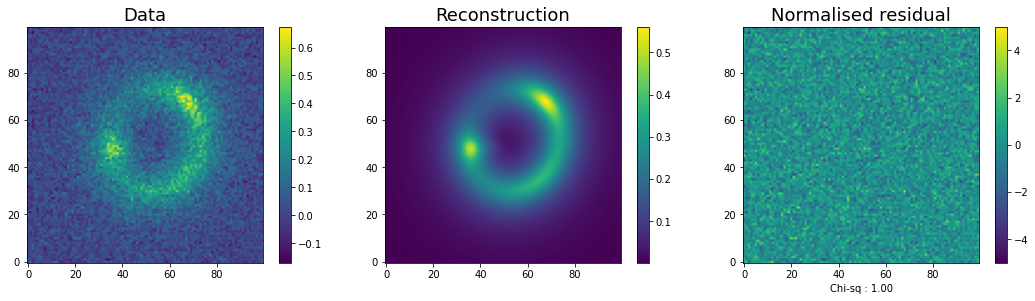

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(data, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(rec, origin='lower')
ax2.set_title("Reconstruction", fontsize=FS)
img3 = ax3.imshow((data - rec) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
ax3.set_title("Normalised residual", fontsize=FS)
ax3.set_xlabel(f"Chi-sq : {2 * loss(p_final):.2f}")
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

In [15]:
def print_error(name, value, estimate):
    spaces = " " * (10 - len(name))
    if value != 0:
        error = 100 * abs(value - estimate) / value
        print(name + ":" + spaces + f"{error:.2f} %")
    else:
        error = abs(value - estimate)
        print(name + ":" + spaces + f"{error:.2f} (abs)")

print("Error")
print("-----")
for i, params in enumerate(kwargs_lens_mass):
    for key, value in params.items():
        fit = p_final['kwargs_lens_mass'][i][key]
        print_error(key, value, fit)


Error
-----
theta_E:   0.41 %
e1:        8.55 %
e2:        -8.31 %
center_x:  0.00 (abs)
center_y:  0.01 (abs)
gamma1:    -49.79 %
gamma2:    7.44 %
